# 대회 설명

- 해당 Deep Knowledge Tracing(DKT) 대회는 사용자의 과거 문제정답 여부에 따른 다음 문제에 대한 정답 여부를 예측해야한다.
- 사용자별 다음 문제를 맞출지 못맞출지 예측을 해야한다.

In [375]:
train_df.loc[train_df['solvingtime'] > 500]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,solvingtime
85,0,A080010001,A080000010,1,2020-04-25 22:05:11,1444,785
356,0,A060078003,A060000078,1,2020-07-02 02:24:03,9590,2349
619,0,A080102001,A080000102,1,2020-10-16 19:11:03,7170,3998
620,0,A080102002,A080000102,1,2020-10-16 20:17:41,7170,619
686,0,A020192004,A020000192,1,2020-10-26 12:02:18,8092,1116
...,...,...,...,...,...,...,...
2266451,7432,A060161001,A060000161,0,2020-07-28 03:38:34,1531,1596
2266455,7432,A060161005,A060000161,1,2020-07-28 04:13:15,1494,873
2266456,7432,A060161006,A060000161,1,2020-07-28 04:27:48,1494,2251
2266532,7437,A040072003,A040000072,1,2020-03-24 07:46:15,2076,546


In [ ]:
train_df.loc[train_df['testId'] == 'A060000078']
train_df.loc[train_df['testId'] == 'A020000192']
train_df.loc[train_df['testId'] == 'A080000102']

In [262]:
train_df.loc[(train_df['assessmentItemID'] == 'A060078003') | (train_df['assessmentItemID'] == 'A060078004')]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
356,0,A060078003,A060000078,1,2020-07-02 02:24:03,9590
357,0,A060078004,A060000078,1,2020-07-02 03:03:12,9590
23152,32,A060078003,A060000078,1,2020-05-30 10:31:12,9590
23153,32,A060078004,A060000078,1,2020-05-30 10:31:53,9590
26912,36,A060078003,A060000078,1,2020-05-18 12:02:21,9590
...,...,...,...,...,...,...
2131629,5037,A060078004,A060000078,1,2020-05-22 05:08:23,9590
2171167,5411,A060078003,A060000078,0,2020-08-31 13:18:32,9590
2171168,5411,A060078004,A060000078,0,2020-08-31 13:18:35,9590
2231336,6306,A060078003,A060000078,1,2020-07-16 08:30:44,9590


In [ ]:
pip install catboost

In [2]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as spst

from eda_tool import null_check, nunique, count_plot, kde_hist_plot, extract_datetime, extract_testId, extract_assessmentItemID
from sklearn.metrics import accuracy_score, roc_auc_score
from catboost import CatBoostClassifier
from statsmodels.tsa.seasonal import STL
from statsmodels.api import Logit
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.chained_assignment',  None)

In [3]:
train_df = pd.read_csv("../data/train_data.csv")
test_df = pd.read_csv("../data/test_data.csv")
train_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


Optimization terminated successfully.
         Current function value: 0.637653
         Iterations 4


trend_solvingtime    0.0
dtype: float64

## 단변량 분석

### 데이터 설명

- userID : 사용자의 고유번호입니다. 총 7,442명의 고유 사용자가 있으며, train/test셋은 이 userID를 기준으로 90/10의 비율로 나누어졌습니다.
- assessmentItemID : 문항의 고유번호입니다. 총 9,454개의 고유 문항이 있습니다. 이 일련 번호에 대한 규칙은 DKT 2강 EDA에서 다루었으니 강의 들어보시면 좋을 것 같습니다.
- testId : 시험지의 고유번호입니다. 문항과 시험지의 관계는 아래 그림을 참고하여 이해하시면 됩니다. 총 1,537개의 고유한 시험지가 있습니다.
- answerCode : 사용자가 해당 문항을 맞췄는지 여부에 대한 이진 데이터이며 0은 사용자가 해당 문항을 틀린 것, 1은 사용자가 해당 문항을 맞춘 것입니다.
- Timestamp : 사용자가 해당문항을 풀기 시작한 시점의 데이터입니다.
- KnowledgeTag : 문항 당 하나씩 배정되는 태그로, 일종의 중분류 역할을 합니다. 태그 자체의 정보는 비식별화 되어있지만, 문항을 군집화하는데 사용할 수 있습니다. 912개의 고유 태그가 존재합니다.

### 결측치
- train / test의 모든 column에 대해 결측치가 존재하지 않습니다.

In [4]:
null_check(train_df, test_df)

[TRAIN] userID's null : 0
[TEST] userID's null : 0
[TRAIN] assessmentItemID's null : 0
[TEST] assessmentItemID's null : 0
[TRAIN] testId's null : 0
[TEST] testId's null : 0
[TRAIN] answerCode's null : 0
[TEST] answerCode's null : 0
[TRAIN] Timestamp's null : 0
[TEST] Timestamp's null : 0
[TRAIN] KnowledgeTag's null : 0
[TEST] KnowledgeTag's null : 0


### userID
- train에는 6698, test에는 744명의 유저가 존재합니다.
- 7442명의 유저를 9:1의 비율로 train / test로 나눈 것 입니다.

In [5]:
column = 'userID'
nunique(train_df, test_df, column)

[TRAIN] userID's number of unique : 6698
[TEST] userID's number of unique : 744
TRAIN userID's unique values are equal to TEST ? : False


### assessmentItemID
- train에 있는 문제들과 test에 있는 문제들이 정확히 같습니다. (개수, 문제번호 모두 동일)
- 해당 컬럼과 timestamp 컬럼을 이용해 문제별 사용자들의 평균 풀이 시간을 구할 수 있습니다.
- 해당 컬럼과 timestamp 컬럼을 이용해 유저별 평균 문제 풀이 시간을 구할 수 있습니다.
- 해당 컬럼을 이용해 문제별 유저들의 정답 비율을 알 수 있습니다.
- 유저들의 정답 비율은 문제의 난이도를 의미한다고 할 수 있습니다. (정답 비율이 낮으면 난이도가 높은 것이고 문제 풀이시간과 분석을 통해 검증을 해보면 될 것 같습니다.)

In [6]:
column = 'assessmentItemID'
nunique(train_df, test_df, column)

[TRAIN] assessmentItemID's number of unique : 9454
[TEST] assessmentItemID's number of unique : 9454
TRAIN assessmentItemID's unique values are equal to TEST ? : True


### testId
- 문제가 같기 때문에 문제집 또한 모두 동일한 것으로 추측됩니다.
- 해당 컬럼과 assessmentItemID 컬럼을 이용해 시험지 별 평균 맞춘 문제 수를 구할 수 있습니다.
- 시험지 별 평균 맞춘 문제 수는 문제집의 난이도를 의미한다고 추측 가능합니다.

In [7]:
column = 'testId'
nunique(train_df, test_df, column)

[TRAIN] testId's number of unique : 1537
[TEST] testId's number of unique : 1537
TRAIN testId's unique values are equal to TEST ? : True


### answerCode
- train에는 맞췄는지 (1) 못맞췄는지 (0)에 대한 값만 존재합니다.
- 반면 test에는 맞췄는지 (1) 못맞췄는지 (0)와 더불어 각 유저의 마지막으로 푼 문제의 다음 문제를 나타내는 값(-1)이 존재합니다.

In [8]:
column = 'answerCode'
nunique(train_df, test_df, column)

[TRAIN] answerCode's number of unique : 2
[TEST] answerCode's number of unique : 3
TRAIN answerCode's unique values are equal to TEST ? : False


### Timestamp
- 각 유저가 각 문제를 풀기 시작한 시간을 나타냅니다.
- 그렇기에 train / test의 고유값 구성이 다른 것이 당연해 보입니다.
- Timestamp를 통해 현재 문제를 풀기 시작한 시간과 다음 문제를 시작한 시간을 이용해 한 문제를 푸는데 걸린 시간을 구할 수 있어보입니다.
- 시계열 관점에서 접근을 한다면 decomposition을 통해 인사이트를 얻을 수 있을 것 같습니다. (decomposition 결과를 피쳐로 사용할 수도 있습니다.)
- 00~12시 사이에 문제를 많이 풀었고, 13~23시 사이에는 그에 비해 문제를 적게 푼 모습이 보입니다.
- 새벽 시간 내내 문제 풀이가 많았던 것을 보아 실제 데이터가 아닌 것 같다는 생각도 듭니다.
- 월별로 봤을 때 차이가 보입니다.

In [9]:
column = 'Timestamp'
nunique(train_df, test_df, column)

[TRAIN] Timestamp's number of unique : 2076774
[TEST] Timestamp's number of unique : 256622
TRAIN Timestamp's unique values are equal to TEST ? : False


In [10]:
hour_train = train_df[column].apply(lambda x : x.split(' ')[1][:2].strip())
hour_train = hour_train.to_frame()
hour_train = hour_train.sort_values(by=column)

hour_test = test_df[column].apply(lambda x : x.split(' ')[1][:2].strip())
hour_test = hour_test.to_frame()
hour_test = hour_test.sort_values(by=column)

custom_palette_hour_train = {}
custom_palette_hour_test = {}

for h, cnt in zip(hour_train.value_counts().index, hour_train.value_counts()):
    h = h[0]
    threshold = 100000
    if threshold < cnt:
        custom_palette_hour_train[h] = 'r'
    else:
        custom_palette_hour_train[h] = 'b'

for h, cnt in zip(hour_test.value_counts().index, hour_test.value_counts()):
    h = h[0]
    threshold = 10000
    if threshold < cnt:
        custom_palette_hour_test[h] = 'r'
    else:
        custom_palette_hour_test[h] = 'b'

In [11]:
train_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


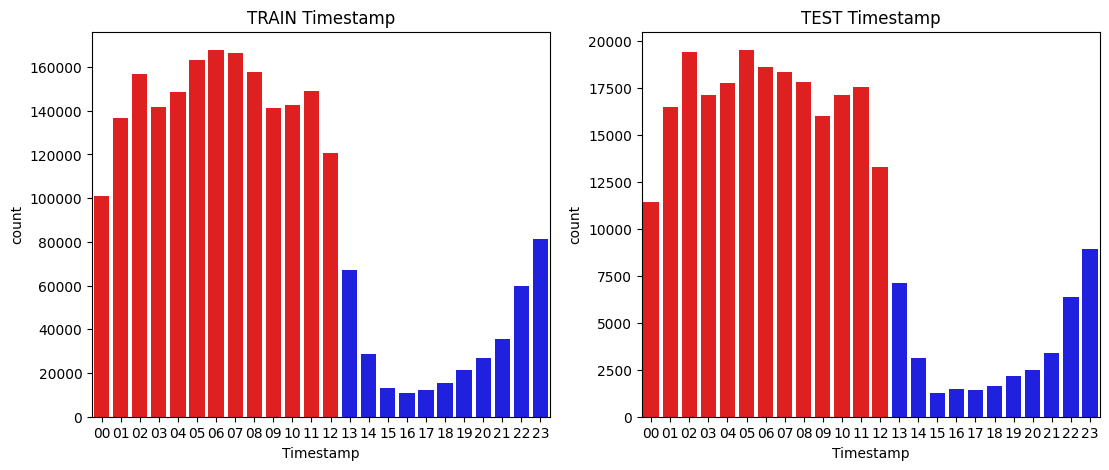

In [12]:
count_plot(hour_train, hour_test, column, custom_palette_hour_train, custom_palette_hour_test)

In [13]:
month_train = train_df[column].apply(lambda x : x.split(' ')[0][5:7].strip())
month_train = month_train.to_frame()
month_train = month_train.sort_values(by=column)

month_test = test_df[column].apply(lambda x : x.split(' ')[0][5:7].strip())
month_test = month_test.to_frame()
month_test = month_test.sort_values(by=column)

custom_palette_month_train = {}
custom_palette_month_test = {}

for h, cnt in zip(month_train.value_counts().index, month_train.value_counts()):
    h = h[0]
    threshold = 200000
    if threshold < cnt:
        custom_palette_month_train[h] = 'r'
    else:
        custom_palette_month_train[h] = 'b'

for h, cnt in zip(month_test.value_counts().index, month_test.value_counts()):
    h = h[0]
    threshold = 25000
    if threshold < cnt:
        custom_palette_month_test[h] = 'r'
    else:
        custom_palette_month_test[h] = 'b'

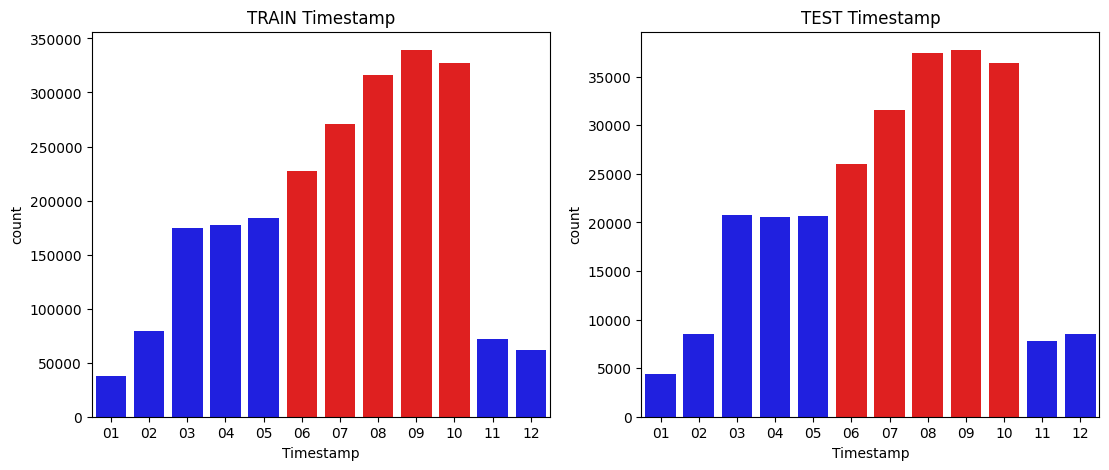

In [14]:
count_plot(month_train, month_test, column, custom_palette_month_train, custom_palette_month_test)

### KnowledgeTag
- train / test의 문제가 모두 동일하게 구성되어 있기에 KnowledgeTag도 같은 고유값들을 갖습니다.
- 대회 데이터 설명에 쓰여있듯이 비슷한 유형의 문제를 찾아내기 위해서 클러스터링을 사용할 수 있습니다.

In [15]:
column = 'KnowledgeTag'
nunique(train_df, test_df, column)

[TRAIN] KnowledgeTag's number of unique : 912
[TEST] KnowledgeTag's number of unique : 912
TRAIN KnowledgeTag's unique values are equal to TEST ? : True


## 이변량 분석

### userID vs answerCode(target)
- 시각적으로는 유저별로 정답 여부에 대한 차이가 있어보입니다.
- 하지만 카이제곱검정을 통해 확인을 했을 때, 카이제곱검정량이 자유도의 2~3배정도의 수치가 나왔기에 관계가 있다고 볼 수 있습니다.

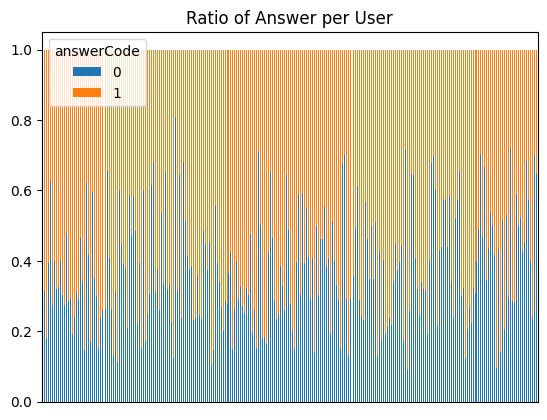

In [16]:
column, target = "userID", "answerCode"

# 유저별 정답비율
ct1 = pd.crosstab(train_df[column], train_df[target], normalize="index")
ct2 = pd.crosstab(train_df[column], train_df[target])
# print(ct)
ct1.plot.bar(stacked=True)
plt.gca().axes.xaxis.set_visible(False)
plt.title("Ratio of Answer per User")
plt.show()

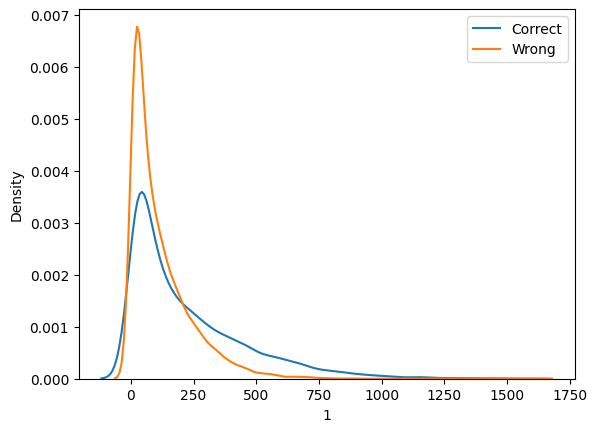

In [18]:
sns.kdeplot(x=1, data=ct2, label="Correct")
sns.kdeplot(x=0, data=ct2, label="Wrong")
plt.legend()
plt.show()

In [22]:
ct2[1].describe().to_frame()

,1
count,6698.000000
mean,221.439982
std,228.725932
min,0.000000
25%,46.000000
50%,140.000000
75%,327.000000
max,1552.000000


In [23]:
result = spst.chi2_contingency(ct2)
print("카이제곱통계량", result[0])
print("p-value", result[1])
print("자유도", result[2])
print("기대빈도\n", result[3])

카이제곱통계량 220990.0098321658
p-value 0.0
자유도 6697
기대빈도
 [[257.48806575 487.51193425]
 [322.46491993 610.53508007]
 [ 95.39155188 180.60844812]
 ...
 [  5.52994504  10.47005496]
 [  5.18432347   9.81567653]
 [  3.11059408   5.88940592]]


### user_answerRatio
- userID를 통해 유저의 정답 비율을 의미하는 user_answerRatio를 만들어 냈습니다.

In [ ]:
ct1_dict = {key : val for key, val in zip(ct1[1].keys(), ct1[1].values)}
train_df['user_answerRatio'] = train_df['userID'].map(ct1_dict)

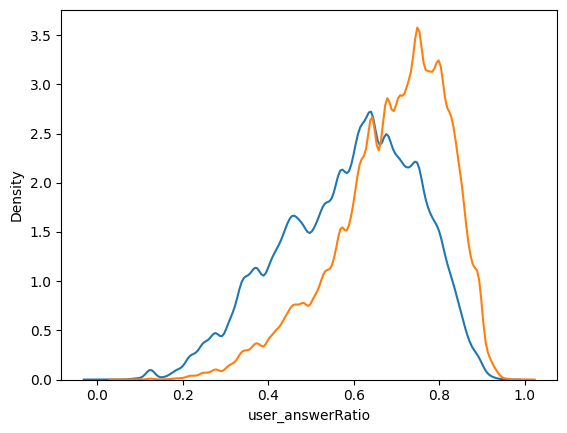

In [66]:
# 시각화 결과를 보면 두 변수가 어느정도 관계가 있습니다.
a0 = train_df.loc[train_df['answerCode']==0]
a1 = train_df.loc[train_df['answerCode']==1]
sns.kdeplot(x='user_answerRatio', data=a0, label="Wrong")
sns.kdeplot(x='user_answerRatio', data=a1, label="Correct")
plt.show()

<AxesSubplot: xlabel='user_answerRatio', ylabel='Density'>

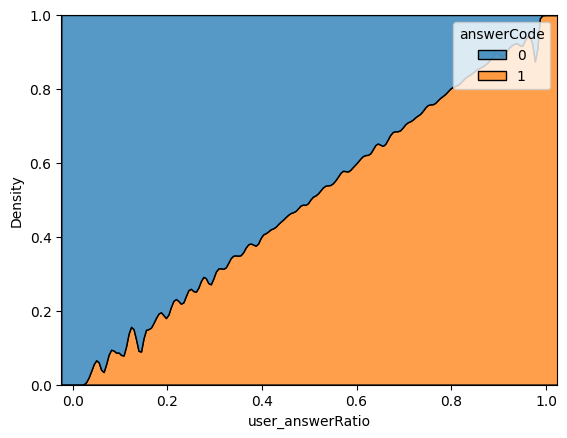

In [68]:
# user_answerRatio가 증가함에 따라 정답의 비율이 올라갑니다. 이것은 당연한 이야기이죠.
# 하지만 user_answerRatio를 유저의 현재까지의 실력이라고 의미를 부여할 수 있을 것 같습니다.
sns.kdeplot(x='user_answerRatio', data=train_df, hue='answerCode', multiple='fill')
plt.show()

In [67]:
# pvalue가 0.05 이하이므로 두 변수가 어느정도 관련이 있습니다.
model = Logit(train_df['answerCode'], train_df['user_answerRatio'])
result = model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.624001
         Iterations 5
user_answerRatio    0.0
dtype: float64


In [69]:
train_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_answerRatio,assessmentItemCode,testClass,testCode,solvingtime,trend_solvingtime,seasonal_solvingtime,resid_solvingtime
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.630872,1,6,1,3,11.093614,0.637499,-8.731113e+00
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,0.630872,2,6,1,8,13.505966,45.555097,-5.106106e+01
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,0.630872,3,6,1,7,15.874614,3.981647,-1.285626e+01
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,0.630872,4,6,1,7,18.198388,-17.703348,6.504960e+00
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,0.630872,5,6,1,11,20.476724,23.894059,-3.337078e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,0.555556,5,3,71,60,48.905977,11.094023,-7.105427e-15
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,0.555556,1,4,165,11,48.905977,-37.905977,0.000000e+00
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,0.555556,2,4,165,46,48.905977,-2.905977,-7.105427e-15
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,0.555556,3,4,165,73,48.905977,24.094023,7.105427e-15


### assessmentItemID vs answerCode
- 

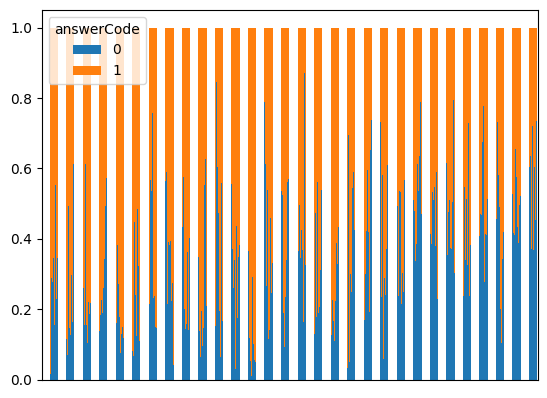

In [24]:
column, target = "assessmentItemID", "answerCode"

# 문제별 정답비율
ct1 = pd.crosstab(train_df[column], train_df[target], normalize="index")
ct2 = pd.crosstab(train_df[column], train_df[target])
# print(ct)

ct1.plot.bar(stacked=True)
plt.gca().axes.xaxis.set_visible(False)
plt.show()

In [25]:
result = spst.chi2_contingency(ct2)
print("카이제곱통계량", result[0])
print("p-value", result[1])
print("자유도", result[2])
print("기대빈도\n", result[3])

카이제곱통계량 388071.41183004796
p-value 0.0
자유도 9453
기대빈도
 [[109.56203603 207.43796397]
 [109.56203603 207.43796397]
 [109.56203603 207.43796397]
 ...
 [ 15.55297041  29.44702959]
 [ 15.55297041  29.44702959]
 [ 15.55297041  29.44702959]]


#### assessmentItemCode
- assessmentItemID를 통해 assessmentItemCode를 만들었습니다.
- 해당 피쳐와 answerCode간의 plot을 보았을 때, 1~13순으로 난이도라고 예상할 수 있을 것 같습니다.
- 앞쪽에는 쉬운 문제이기에 정답비율이 높고 뒤쪽에는 어려운 문제이기에 정답비율이 낮다는 가정입니다.

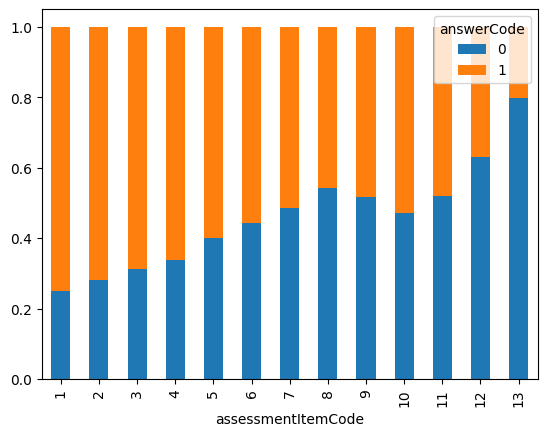

In [26]:
train_df = extract_assessmentItemID(train_df)
ct3 = pd.crosstab(train_df['assessmentItemCode'], train_df[target], normalize="index")
ct4 = pd.crosstab(train_df['assessmentItemCode'], train_df[target])
ct3.plot.bar(stacked=True)
# plt.gca().axes.xaxis.set_visible(False)
plt.show()

In [27]:
result = spst.chi2_contingency(ct4)
print("카이제곱통계량", result[0])
print("p-value", result[1])
print("자유도", result[2])
print("기대빈도\n", result[3])

카이제곱통계량 64216.066146902456
p-value 0.0
자유도 12
기대빈도
 [[1.28486545e+05 2.43268455e+05]
 [1.28215923e+05 2.42756077e+05]
 [1.28446798e+05 2.43193202e+05]
 [1.27778021e+05 2.41926979e+05]
 [1.24633556e+05 2.35973444e+05]
 [6.83542681e+04 1.29417732e+05]
 [4.39357589e+04 8.31852411e+04]
 [2.32084881e+04 4.39415119e+04]
 [6.36531236e+03 1.20516876e+04]
 [1.84631040e+03 3.49568960e+03]
 [1.15852349e+03 2.19347651e+03]
 [8.58523967e+02 1.62547603e+03]
 [9.29722009e+01 1.76027799e+02]]


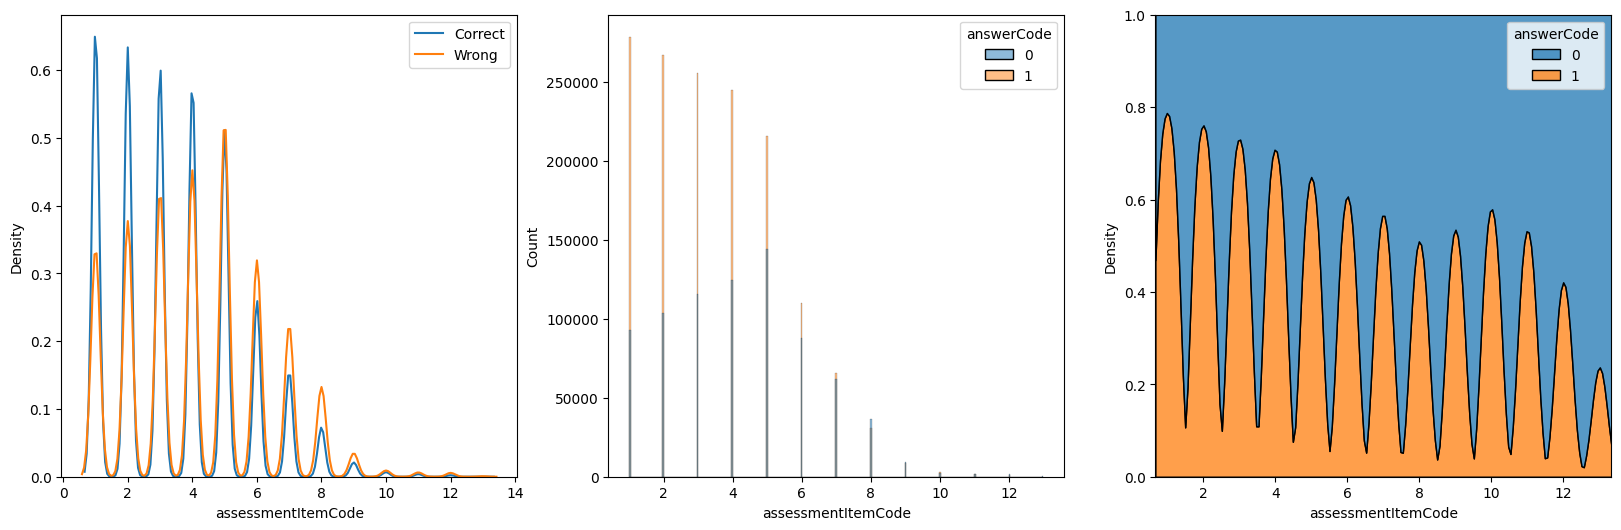

In [28]:
kde_hist_plot(train_df, 'assessmentItemCode')

### testId vs answerCode
- testId를 그대로 봤을 때도 testId별 정답 비율 차이가 조금은 있어보입니다.

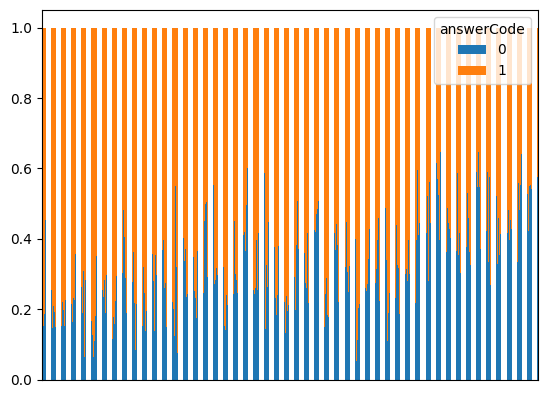

In [29]:
column, target = "testId", "answerCode"

# 문제집별 정답비율
ct1 = pd.crosstab(train_df[column], train_df[target], normalize="index")
ct2 = pd.crosstab(train_df[column], train_df[target])
# print(ct)

ct1.plot.bar(stacked=True)
plt.gca().axes.xaxis.set_visible(False)
plt.show()

In [30]:
result = spst.chi2_contingency(ct2)
print("카이제곱통계량", result[0])
print("p-value", result[1])
print("자유도", result[2])
print("기대빈도\n", result[3])

카이제곱통계량 207750.04485255096
p-value 0.0
자유도 1536
기대빈도
 [[ 547.81018016 1037.18981984]
 [ 535.71342539 1014.28657461]
 [ 558.1788271  1056.8211729 ]
 ...
 [  93.31782249  176.68217751]
 [  93.31782249  176.68217751]
 [  93.31782249  176.68217751]]


#### testClass & testCode
- testId를 통해 시험지 분류를 위한 testClass를 만들었습니다.
- testId를 통해 testCode를 만들었습니다.
- testClass와 answerCode의 관계를 시각화를 통해 보았을 때, 근소한 차이지만 7~9보다 1~6의 정답 비율이 더 높았습니다.

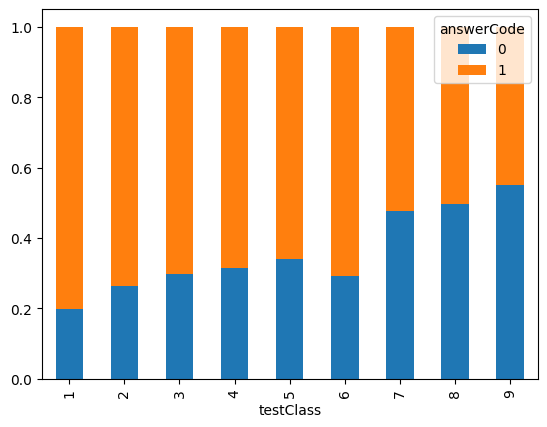

In [33]:
train_df = extract_testId(train_df)
ct3 = pd.crosstab(train_df['testClass'], train_df[target], normalize="index")
ct4 = pd.crosstab(train_df['testClass'], train_df[target])

ct3.plot.bar(stacked=True)
plt.show()

In [34]:
result = spst.chi2_contingency(ct4)
print("카이제곱통계량", result[0])
print("p-value", result[1])
print("자유도", result[2])
print("기대빈도\n", result[3])

카이제곱통계량 110206.32541325112
p-value 0.0
자유도 8
기대빈도
 [[ 94037.40658506 178044.59341494]
 [ 92739.59760936 175587.40239064]
 [ 94618.05081387 179143.94918613]
 [ 92392.59355833 174930.40644167]
 [ 95313.09578061 180459.90421939]
 [ 91394.09285772 173039.90714228]
 [ 96485.09850674 182678.90149326]
 [ 85139.03377856 161196.96622144]
 [ 41262.03050976  78122.96949024]]


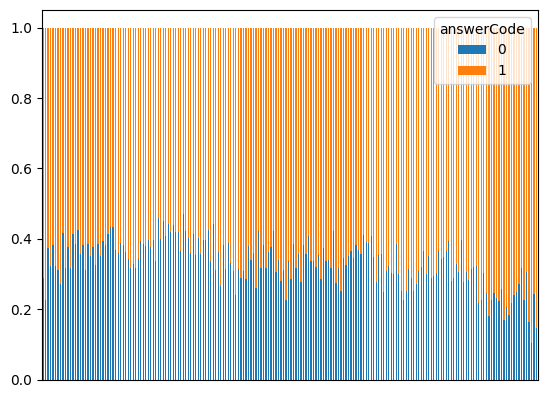

In [35]:
ct5 = pd.crosstab(train_df['testCode'], train_df[target], normalize="index")
ct6 = pd.crosstab(train_df['testCode'], train_df[target])

ct5.plot.bar(stacked=True)
plt.gca().axes.xaxis.set_visible(False)
plt.show()

In [36]:
result = spst.chi2_contingency(ct6)
print("카이제곱통계량", result[0])
print("p-value", result[1])
print("자유도", result[2])
print("기대빈도\n", result[3])

카이제곱통계량 33814.54596978065
p-value 0.0
자유도 197
기대빈도
 [[ 5153.56315225  9757.43684775]
 [ 4282.25118747  8107.74881253]
 [ 5865.1979541  11104.8020459 ]
 [ 4262.20513671  8069.79486329]
 [ 5642.27204483 10682.72795517]
 [ 4144.34818313  7846.65181687]
 [ 5815.42844878 11010.57155122]
 [ 4377.64273934  8288.35726066]
 [ 6067.38656949 11487.61343051]
 [ 4292.61983441  8127.38016559]
 [ 5885.58962642 11143.41037358]
 [ 4087.6662465   7739.3337535 ]
 [ 5708.63138526 10808.36861474]
 [ 4793.42548176  9075.57451824]
 [ 5680.63603852 10755.36396148]
 [ 5339.16193253 10108.83806747]
 [ 6130.98093741 11608.01906259]
 [ 5771.18888849 10926.81111151]
 [ 5547.22611452 10502.77388548]
 [ 4701.49014553  8901.50985447]
 [ 5098.26370188  9652.73629812]
 [ 4921.99670385  9319.00329615]
 [ 5319.46150334 10071.53849666]
 [ 4882.59584547  9244.40415453]
 [ 5524.76071281 10460.23928719]
 [ 4876.02903574  9231.97096426]
 [ 5132.82585836  9718.17414164]
 [ 4826.95077354  9139.04922646]
 [ 5156.67374633  9763.3

In [37]:
for i in range(1, 10):
    print(f"testClass {i}'s length : {len(train_df.loc[train_df['testClass']==i])}")

testClass 1's length : 272082
testClass 2's length : 268327
testClass 3's length : 273762
testClass 4's length : 267323
testClass 5's length : 275773
testClass 6's length : 264434
testClass 7's length : 279164
testClass 8's length : 246336
testClass 9's length : 119385


### Timestamp vs answerCode
- 문제 풀이시간 컬럼을 만들어서 decomposition을 수행했습니다.
- decomposition 결과 값들과 answerCode의 관계를 시각화 했을 때, 풀이시간에 따른 차이가 있어보입니다.

In [39]:
train_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_answerRatio,assessmentItemCode,testClass,testCode,solvingtime
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.630872,1,6,1,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,0.630872,2,6,1,0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,0.630872,3,6,1,0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,0.630872,4,6,1,0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,0.630872,5,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,0.555556,5,3,71,0
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,0.555556,1,4,165,0
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,0.555556,2,4,165,0
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,0.555556,3,4,165,0


In [42]:
train_df['solvingtime'] = 0
solvingtime = np.array([0 for _ in range(len(train_df))])
trend = np.array([0 for _ in range(len(train_df))], dtype=float)
seasonal = np.array([0 for _ in range(len(train_df))], dtype=float)
resid = np.array([0 for _ in range(len(train_df))], dtype=float)

train_decompose_col = {'trend_solvingtime' : trend,
                       'seasonal_solvingtime' : seasonal,
                       'resid_solvingtime' : resid}

for userid in tqdm(train_df['userID'].unique()):
    dummy = train_df.loc[train_df['userID']==userid].copy()
    dummy['endtime'] = dummy['Timestamp'].shift(-1)
    grouped = dummy.groupby(by=['testId'])
    for key, group in grouped:
        indices = group.index
        group.iloc[-1, -1] = pd.to_datetime(group.iloc[-2, -1]) + datetime.timedelta(seconds=60)
        group['solvingtime'] = pd.to_datetime(group['endtime']) - pd.to_datetime(group['Timestamp'])
        solvingtime[indices] = group['solvingtime'].apply(lambda x : x.seconds if x.seconds < 2000 else 60)
        dummy['solvingtime'][indices] = group['solvingtime'].apply(lambda x : x.seconds if x.seconds < 2000 else 60)

    res = STL(dummy.set_index(dummy['Timestamp'])['solvingtime'], period=24).fit()
    dummy_indices = dummy.index
    train_decompose_col['trend_solvingtime'][dummy_indices] = res.trend.values
    train_decompose_col['seasonal_solvingtime'][dummy_indices] = res.seasonal.values
    train_decompose_col['resid_solvingtime'][dummy_indices] = res.resid.values

train_df['solvingtime'] = solvingtime
train_df = pd.concat([train_df, pd.DataFrame(train_decompose_col)], axis=1)

100%|██████████| 6698/6698 [17:22<00:00,  6.42it/s]


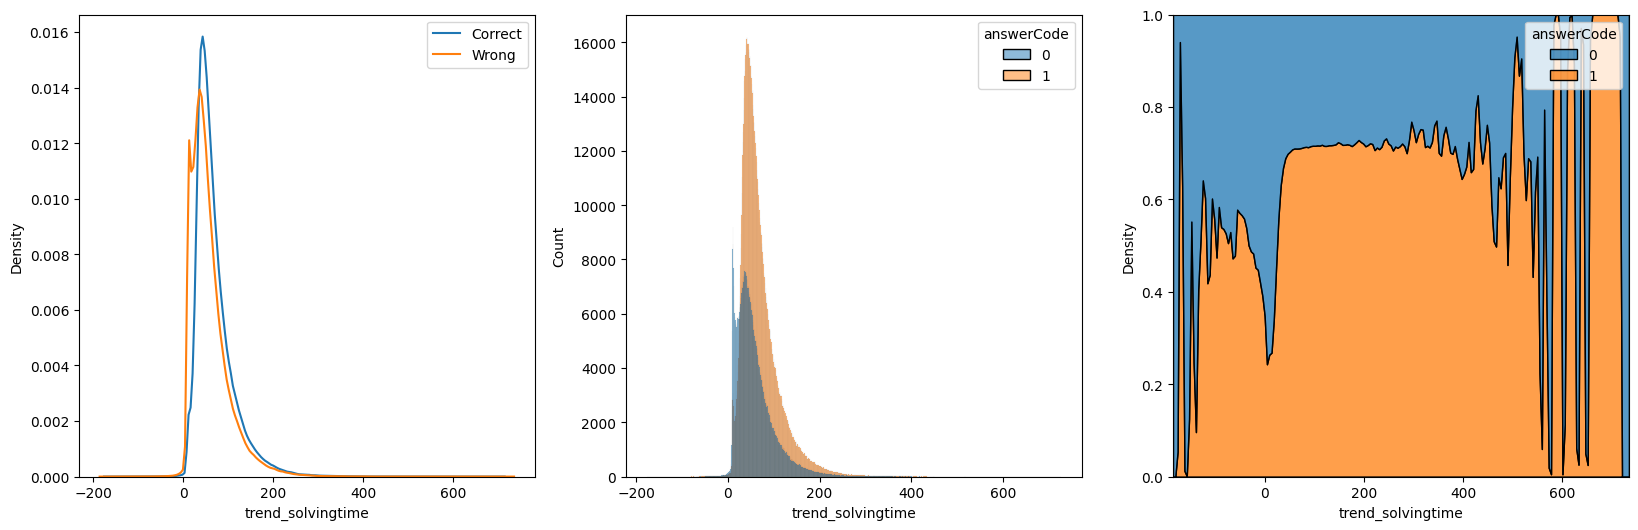

In [58]:
kde_hist_plot(train_df, 'trend_solvingtime')

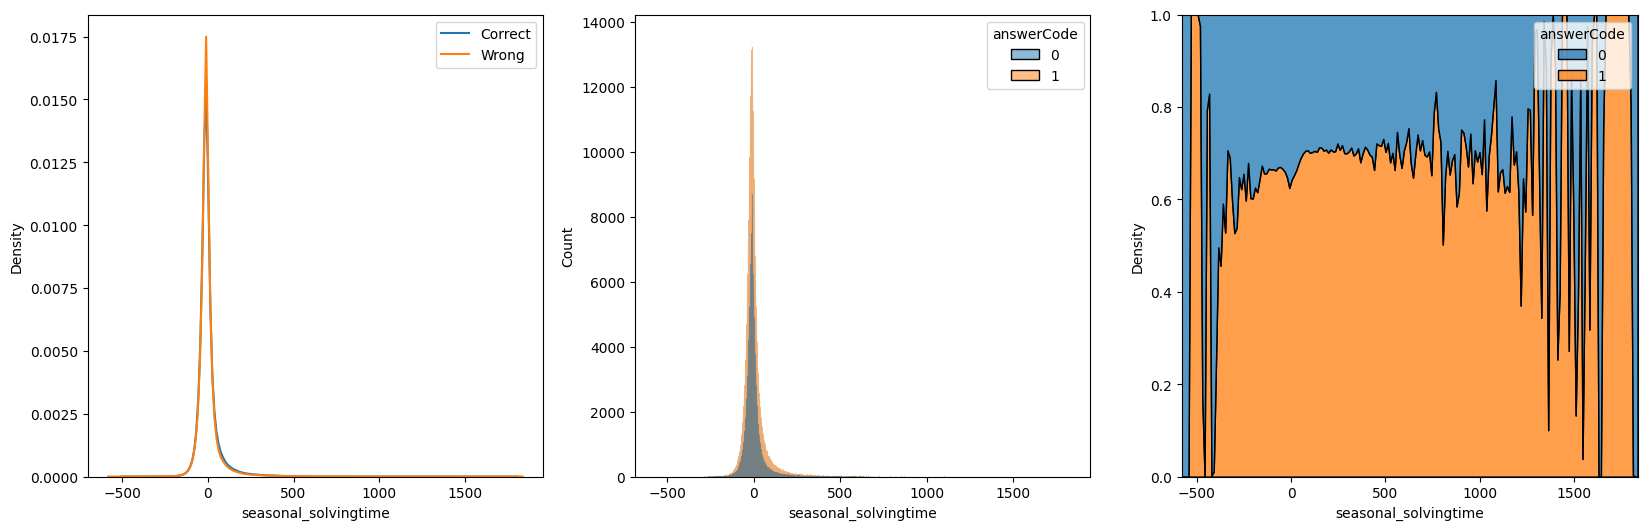

In [59]:
kde_hist_plot(train_df, 'seasonal_solvingtime')

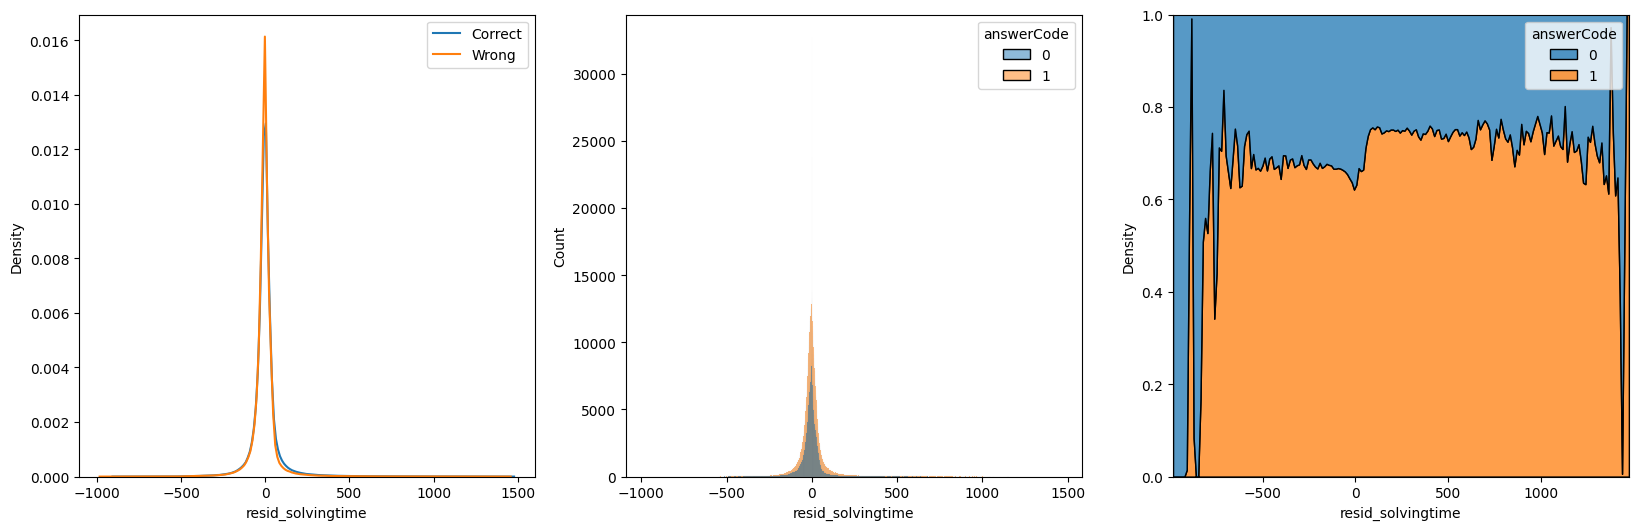

In [60]:
kde_hist_plot(train_df, 'resid_solvingtime')

### KnowledgeTag vs answerCode
- 

In [64]:
train_df['KnowledgeTag'].value_counts()

7597    12892
7600    10734
2010    10176
7621     9709
8127     9006
        ...  
5142       47
2871       46
4978       46
7125       45
2613       44
Name: KnowledgeTag, Length: 912, dtype: int64

In [ ]:
test_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623
...,...,...,...,...,...,...
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832
260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244
260112,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244


In [ ]:
# 유저별 문제집별 맞춘 문제수, 해당 문제집 문제수 확인
user_test_answer_ratio = test_df.groupby(by=["userID", "testId"], as_index=False)["assessmentItemID", "answerCode"].agg({"assessmentItemID" : pd.value_counts, "answerCode" : sum})
user_test_answer_ratio['assessmentItemID_cnt'] = user_test_answer_ratio['assessmentItemID'].apply(lambda x: len(x))
user_test_answer_ratio['answer_ratio_per_test'] = user_test_answer_ratio['answerCode'] / user_test_answer_ratio['assessmentItemID_cnt']
user_test_answer_ratio

/tmp/ipykernel_9270/2779260142.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  user_test_answer_ratio = test_df.groupby(by=["userID", "testId"], as_index=False)["assessmentItemID", "answerCode"].agg({"assessmentItemID" : pd.value_counts, "answerCode" : sum})


,userID,testId,assessmentItemID,answerCode,assessmentItemID_cnt,answer_ratio_per_test
0,3,A020000001,"[1, 1, 1, 1, 1]",4,5,0.800000
1,3,A020000005,"[1, 1, 1, 1, 1]",5,5,1.000000
2,3,A020000007,"[1, 1, 1, 1, 1]",5,5,1.000000
3,3,A020000011,"[1, 1, 1, 1, 1]",5,5,1.000000
4,3,A020000013,"[1, 1, 1, 1, 1]",5,5,1.000000
...,...,...,...,...,...,...
42020,7417,A010000107,"[1, 1, 1, 1, 1, 1]",0,6,0.000000
42021,7417,A050000193,"[1, 1, 1, 1]",1,4,0.250000
42022,7439,A040000003,"[1, 1, 1, 1, 1]",4,5,0.800000
42023,7439,A040000130,"[1, 1, 1, 1, 1]",2,5,0.400000


In [ ]:
# 문제집 별 유저들의 평균 정답률
user_test_answer_ratio.groupby(by=["testId"])["answer_ratio_per_test"].mean().to_frame()

,answer_ratio_per_test
testId,
A010000001,0.925000
A010000002,0.953846
A010000003,0.830769
A010000004,0.882927
A010000005,0.813333
...,...
A090000070,0.696429
A090000071,0.425000
A090000072,0.766667
